<a href="https://colab.research.google.com/github/StanleyLiangYork/DeepLearningForMalaria/blob/master/predict_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 62kB/s 


In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


1.13.1


In [21]:
# download dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
# download the dataset from UCI 
!rm /root/.keras/datasets/breast-cancer-wisconsin.data
dataset_path = keras.utils.get_file("breast-cancer-wisconsin.data","https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data")
dataset_path

24576/19889 [=====================================] - 0s 4us/step


'/root/.keras/datasets/breast-cancer-wisconsin.data'

In [30]:
column_names = ['Sample code number','Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
               'Normal Nucleoli','Mitoses','Class'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?",
                      sep=",", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [31]:
# find the missing data
dataset.isna().sum()

Sample code number              0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

In [33]:
dataset = dataset.dropna()
sample_num = dataset.pop('Sample code number')
dataset.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2


In [0]:
# split the data for training and test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

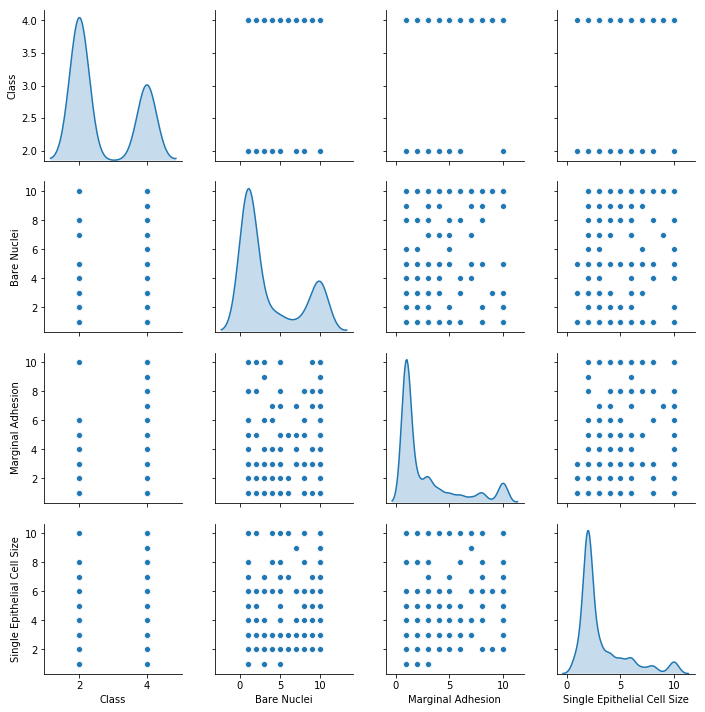

In [37]:
# Inspect the data
sns.pairplot(train_dataset[["Class", "Bare Nuclei", "Marginal Adhesion", "Single Epithelial Cell Size"]], diag_kind='kde')

In [0]:
# remove the true answer from the dataset
Y_train = train_dataset.pop('Class')
Y_test = test_dataset.pop('Class')

In [0]:
X_train = train_dataset
X_test = test_dataset

# convert label to 0 (benign) / 1 (malignant)
Y_train = [1 if y==4 else 0 for y in Y_train]
Y_test = [1 if y==2 else 0 for y in Y_train]

In [0]:
from keras.models import Sequential
from keras.layers import Dense
# form the model
classifier = Sequential()
classifier.add(Dense(units = 16, activation = 'relu', input_shape=[len(train_dataset.keys())]))
classifier.add(Dense(units = 8, activation = 'relu'))
classifier.add(Dense(units = 6, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')

In [57]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                160       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 7         
Total params: 357
Trainable params: 357
Non-trainable params: 0
_________________________________________________________________


In [58]:
# test if the untrained model works
example_batch = X_train[:10]
example_result = classifier.predict(example_batch)
example_result

array([[0.153941  ],
       [0.31108996],
       [0.01708615],
       [0.01044428],
       [0.33611625],
       [0.46739808],
       [0.41373408],
       [0.33164793],
       [0.32788855],
       [0.3276536 ]], dtype=float32)

In [59]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 10 == 0: print('')
    print('.',end='')

EPOCHS = 100

history = classifier.fit(
    X_train, Y_train,
    epochs = EPOCHS, validation_split=0.2, verbose=0, batch_size = 10,
    callbacks = [PrintDot()]
)


..........
..........
..........
..........
..........
..........
..........
..........
..........
..........

In [0]:
Y_pred = classifier.predict(X_test)
Y_pred = [1 if y>=0.5 else 0 for y in Y_pred]

In [63]:
total = 0
correct = 0
wrong = 0
for i in Y_pred:
  total = total + 1
  if(Y_test[i] == Y_pred[i]):
    correct = correct + 1
  else:
    wrong = wrong + 1
 
print("Total: " + str(total))
print("Correct: " + str(correct))
print("Wrong: " + str(wrong))

Total: 137
Correct: 137
Wrong: 0
